In [1]:
import os
import librosa  
import librosa.display
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats, fft
from tqdm import tqdm 

In [2]:
music_genres_dir = '../GTZAN_Dataset/genres_original/'
!ls $music_genres_dir

genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

blues  classical  country  disco  hiphop  jazz	metal  pop  reggae  rock


In [3]:
audio_files = []
labels=[]

for genre in genres :
    genre_path = os.path.join(music_genres_dir, genre)
    for audio_file in tqdm(os.listdir(genre_path)):
        if audio_file.endswith('.wav'):
            audio_files.append(os.path.join(genre_path, audio_file))
            labels.append(genre)

print(f"Number of audio files: {len(audio_files)}")
# create a dataframe
df = pd.DataFrame({'filename': audio_files, 'genre': labels})
df.head()

100%|██████████| 100/100 [00:00<00:00, 750322.72it/s]

Number of audio files: 999


filename  genre
0  ../GTZAN_Dataset/genres_original/blues/blues.0...  blues
1  ../GTZAN_Dataset/genres_original/blues/blues.0...  blues
2  ../GTZAN_Dataset/genres_original/blues/blues.0...  blues
3  ../GTZAN_Dataset/genres_original/blues/blues.0...  blues
4  ../GTZAN_Dataset/genres_original/blues/blues.0...  blues

In [4]:
# load a jazz music file
jazz_file = df[df['genre'] == 'jazz']['filename'].values[0]
y, sr = librosa.load(jazz_file)
print(f"y: {y}")
print(f"y shape: {y.shape}")

y: [0.09100342 0.08599854 0.08410645 ... 0.08886719 0.07849121 0.06893921]
y shape: (661794,)


- y : le signal audio sous forme d'un tableau numpy normalisé entre -1 et 1 
- sr : taux d'echantillonnage par defaut 22050 Hz  

In [5]:
# listen to the audio file
import IPython.display as ipd
ipd.Audio(y, rate=sr)

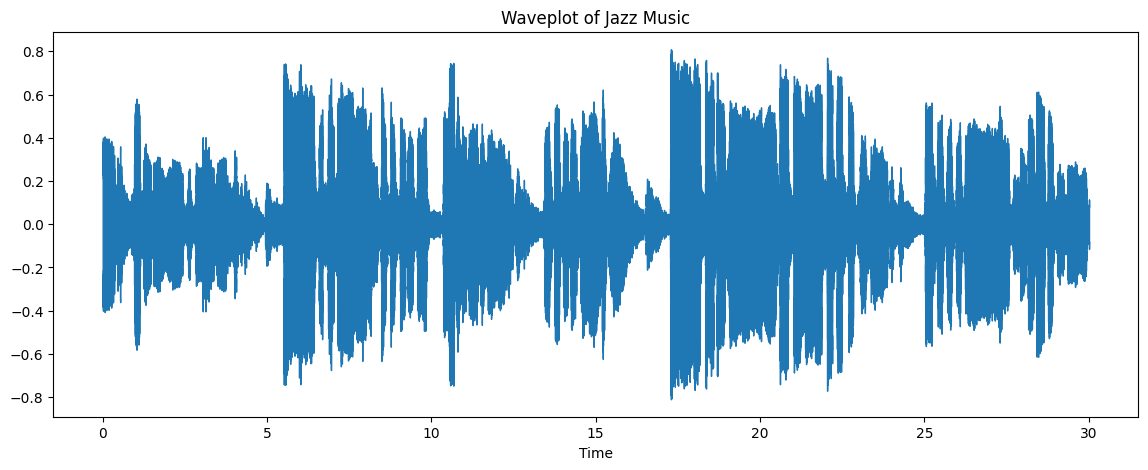

In [6]:
# plot the jazz audio file 
plt.figure(figsize=(14, 5))
librosa.display.waveshow(y, sr=sr)
plt.title('Waveplot of Jazz Music')
plt.show()


In [6]:
# EXtraction et Stockage des caracterisitiques des audios 

features_list = []

for filename, genre in tqdm(zip(df['filename'], df['genre']), total=len(df)):
    try: 

        y, sr = librosa.load(filename)

        features = {
            'genre': genre,
            'duration': librosa.get_duration(y=y, sr=sr),
            'zero_crossing_rate': np.mean(librosa.feature.zero_crossing_rate(y)),
            'rms': np.mean(librosa.feature.rms(y=y)),
            'chromagram': librosa.feature.chroma_stft(y=y, sr=sr),
            'spectral_centroid': np.mean(librosa.feature.spectral_centroid(y=y, sr=sr)),
            'spectral_rolloff': np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr)),
            'spectral_bandwidth': np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))            
        }
        
        tempo, beats = librosa.beat.beat_track(y=y, sr=sr)
        features['tempo'] = float(tempo)
        features['beats_avg'] = np.mean(beats)
        features['onset_strength_mean'] = np.mean(librosa.onset.onset_strength(y=y, sr=sr))
        
        # Features spectrales additionnelles
        features['spectral_contrast'] = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr))
        features['spectral_flatness'] = np.mean(librosa.feature.spectral_flatness(y=y))
        
        # MFCCs et leurs dérivées
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        mfccs_delta = librosa.feature.delta(mfccs)
        mfccs_delta2 = librosa.feature.delta(mfccs, order=2)
        
        # Ajout des MFCCs et leurs dérivées
        for i in range(13):
            features[f'mfcc_{i+1}'] = np.mean(mfccs[i])
            features[f'mfcc_delta_{i+1}'] = np.mean(mfccs_delta[i])
            features[f'mfcc_delta2_{i+1}'] = np.mean(mfccs_delta2[i])
        
        features_list.append(features)
        
    except Exception as e:
        print(f"Erreur avec {filename}: {str(e)}")

features_df = pd.DataFrame(features_list)
features_df

100%|██████████| 999/999 [07:24<00:00,  2.25it/s]


genre   duration  zero_crossing_rate       rms  \
0    blues  30.013333            0.097824  0.110940   
1    blues  30.013333            0.117142  0.106228   
2    blues  30.013333            0.032312  0.063040   
3    blues  30.013333            0.051973  0.077054   
4    blues  30.013333            0.047907  0.101084   
..     ...        ...                 ...       ...   
994   rock  30.013333            0.111517  0.126871   
995   rock  30.013333            0.119886  0.100201   
996   rock  30.013333            0.069055  0.088311   
997   rock  30.013333            0.139201  0.106824   
998   rock  30.013333            0.054960  0.180372   

                                            chromagram  spectral_centroid  \
0    [[0.5320618, 0.4225055, 0.27116325, 0.15157445...        2301.576917   
1    [[0.0668533, 0.052256316, 0.06987246, 0.084031...        2280.154187   
2    [[0.35101873, 0.19009027, 0.16066214, 0.159841...         918.681000   
3    [[0.93996006, 0.6937638, 0.59542847, 0.6226586...        1198.857018   
4    [[0.09662903, 0.022624036, 0.014545803, 0.0727...        1046.775127   
..                                                 ...                ...   
994  [[0.54483753, 0.70488065, 0.39091757, 0.418425...        2301.770038   
995  [[0.13281547, 0.09103189, 0.14713623, 0.495712...        2414.161865   
996  [[0.027145695, 0.0065549817, 0.0064568855, 0.0...        2072.154518   
997  [[0.81945246, 1.0, 0.20115206, 0.05045215, 0.0...        2581.507604   
998  [[0.44235554, 0.21944205, 0.21056882, 0.304418...        1529.290808   

     spectral_rolloff  spectral_bandwidth       tempo   beats_avg  ...  \
0         5187.511839         2367.502276   89.102909  637.571429  ...   
1         4732.983059         2119.794150  112.347147  684.351852  ...   
2         1602.533285         1437.035104   83.354335  663.897436  ...   
3         2478.833064         1573.309953   83.354335  612.410256  ...   
4         1831.221564         1481.055847   99.384014  669.360000  ...   
..                ...                 ...         ...         ...  ...   
994       5092.044641         2355.029060  117.453835  634.881356  ...   
995       5213.041924         2339.259342  103.359375  628.632653  ...   
996       4688.517744         2739.762940   80.749512  660.275000  ...   
997       5390.361940         2376.171881  129.199219  643.353846  ...   
998       3271.448122         1845.370440  151.999081  650.323077  ...   

     mfcc_delta2_10    mfcc_11  mfcc_delta_11  mfcc_delta2_11    mfcc_12  \
0          0.003633 -21.826736       0.001162       -0.001681   9.695747   
1          0.008230  -9.557408      -0.004496       -0.004725   6.359987   
2         -0.000615  -0.874229       0.005344        0.006094  -0.439190   
3         -0.001583   4.199124      -0.002933       -0.002239  -3.283063   
4         -0.003602   3.358221      -0.001829       -0.003455  -1.506644   
..              ...        ...            ...             ...        ...   
994        0.001757  -9.231342      -0.001941        0.001485   9.977349   
995       -0.005345 -12.512172      -0.001972        0.006265   9.378813   
996        0.002442  -5.237825       0.003880        0.001301  -4.842616   
997       -0.002414 -18.290829       0.002563        0.004140  13.340856   
998       -0.004935  -4.547976       0.014347       -0.001151   9.940145   

     mfcc_delta_12  mfcc_delta2_12    mfcc_13  mfcc_delta_13  mfcc_delta2_13  
0         0.008254        0.004109  -2.584758       0.016942        0.001962  
1        -0.002923       -0.004556 -21.088718       0.005437       -0.002091  
2        -0.004431        0.010939   1.485129       0.022170       -0.001016  
3         0.003694        0.005286   1.617682       0.009879        0.001022  
4         0.003428       -0.001921   1.896923       0.014607        0.000950  
..             ...             ...        ...            ...             ...  
994       0.002059        0.001355 -13.473844      -0.009714    

- **duration**: longueur temporelle du signal audio. 
- **zero_crossing_rate**: nombre de fois qu'un signal change de signe.
- **rms**: Root Mean Square mesure de l'amplitude moyenne du signal, pour les signaux audio, cela correspond à peu près à la puissance du signal.
> https://musicinformationretrieval.com/
- **spectral_centroid**: centre de masse du spectre, ou la frequence moyenne pondérée.
- **spectral_rolloff**: frequence en dessous de laquelle se trouve 85% du son.
- **spectral_bandwith**: mesure l'étalement des fréquences autour du centre de masse.

In [7]:
print("Shape du DataFrame:", features_df.shape)
features_df.head()

Shape du DataFrame: (999, 52)


genre   duration  zero_crossing_rate       rms  \
0  blues  30.013333            0.097824  0.110940   
1  blues  30.013333            0.117142  0.106228   
2  blues  30.013333            0.032312  0.063040   
3  blues  30.013333            0.051973  0.077054   
4  blues  30.013333            0.047907  0.101084   

                                          chromagram  spectral_centroid  \
0  [[0.5320618, 0.4225055, 0.27116325, 0.15157445...        2301.576917   
1  [[0.0668533, 0.052256316, 0.06987246, 0.084031...        2280.154187   
2  [[0.35101873, 0.19009027, 0.16066214, 0.159841...         918.681000   
3  [[0.93996006, 0.6937638, 0.59542847, 0.6226586...        1198.857018   
4  [[0.09662903, 0.022624036, 0.014545803, 0.0727...        1046.775127   

   spectral_rolloff  spectral_bandwidth       tempo   beats_avg  ...  \
0       5187.511839         2367.502276   89.102909  637.571429  ...   
1       4732.983059         2119.794150  112.347147  684.351852  ...   
2       1602.533285         1437.035104   83.354335  663.897436  ...   
3       2478.833064         1573.309953   83.354335  612.410256  ...   
4       1831.221564         1481.055847   99.384014  669.360000  ...   

   mfcc_delta2_10    mfcc_11  mfcc_delta_11  mfcc_delta2_11   mfcc_12  \
0        0.003633 -21.826736       0.001162       -0.001681  9.695747   
1        0.008230  -9.557408      -0.004496       -0.004725  6.359987   
2       -0.000615  -0.874229       0.005344        0.006094 -0.439190   
3       -0.001583   4.199124      -0.002933       -0.002239 -3.283063   
4       -0.003602   3.358221      -0.001829       -0.003455 -1.506644   

   mfcc_delta_12  mfcc_delta2_12    mfcc_13  mfcc_delta_13  mfcc_delta2_13  
0       0.008254        0.004109  -2.584758       0.016942        0.001962  
1      -0.002923       -0.004556 -21.088718       0.005437       -0.002091  
2      -0.004431        0.010939   1.485129       0.022170       -0.001016  
3       0.003694        0.005286   1.617682       0.009879        0.001022  
4       0.003428       -0.001921   1.896923       0.014607        0.000950  

[5 rows x 52 columns]

In [8]:
print("\nStatistiques descriptives des caractéristiques:")
print(features_df.describe())


Statistiques descriptives des caractéristiques:
         duration  zero_crossing_rate         rms  spectral_centroid  \
count  999.000000          999.000000  999.000000         999.000000   
mean    30.024071            0.103651    0.130826        2202.419119   
std      0.080951            0.041824    0.065671         716.076969   
min     29.931973            0.021697    0.005270         570.349904   
25%     30.000181            0.070374    0.086566        1626.527014   
50%     30.013333            0.099503    0.122181        2209.486740   
75%     30.013333            0.132097    0.175621        2691.962733   
max     30.648889            0.274631    0.397734        4435.732059   

       spectral_rolloff  spectral_bandwidth       tempo    beats_avg  \
count        999.000000          999.000000  999.000000   999.000000   
mean        4572.915033         2242.763943  119.293183   643.728517   
std         1575.066700          526.517009   28.086954    51.014696   
min          7

In [8]:
# Read the data from csv
features_df = pd.read_csv('music_features.csv')

In [9]:
# Statistiques descriptives des features numériques
numeric_features = features_df.select_dtypes(include=['float64']).columns
features_df[numeric_features].describe()

duration  zero_crossing_rate         rms  spectral_centroid  \
count  999.000000          999.000000  999.000000         999.000000   
mean    30.024071            0.103651    0.130826        2202.419119   
std      0.080951            0.041824    0.065671         716.076969   
min     29.931973            0.021697    0.005270         570.349904   
25%     30.000181            0.070374    0.086566        1626.527014   
50%     30.013333            0.099503    0.122181        2209.486740   
75%     30.013333            0.132097    0.175621        2691.962733   
max     30.648889            0.274631    0.397734        4435.732059   

       spectral_rolloff  spectral_bandwidth       tempo    beats_avg  \
count        999.000000          999.000000  999.000000   999.000000   
mean        4572.915033         2242.763943  119.293183   643.728517   
std         1575.066700          526.517009   28.086954    51.014696   
min          749.740169          900.409298   58.726918   173.266667   
25%         3380.209117         1907.133128   99.384014   633.068182   
50%         4658.516146         2221.373053  117.453835   646.260000   
75%         5534.116472         2578.883006  135.999178   657.817232   
max         8677.730976         3509.656096  234.907670  1135.307692   

       onset_strength_mean  spectral_contrast  ...  mfcc_delta2_10  \
count           999.000000         999.000000  ...      999.000000   
mean              1.418312          20.514742  ...       -0.000662   
std               0.340302           2.181825  ...        0.004894   
min               0.608748          13.493065  ...       -0.016177   
25%               1.162753          18.780411  ...       -0.003871   
50%               1.364845          20.586885  ...       -0.000394   
75%               1.633012          21.959069  ...        0.002434   
max               2.449675          27.926871  ...        0.016370   

          mfcc_11  mfcc_delta_11  mfcc_delta2_11     mfcc_12  mfcc_delta_12  \
count  999.000000     999.000000      999.000000  999.000000     999.000000   
mean    -6.025726      -0.000514        0.001006    4.476135       0.000034   
std      6.819910       0.010577        0.004817    6.718115       0.009924   
min    -28.051817      -0.031414       -0.018678  -15.802279      -0.032119   
25%    -10.971460      -0.007196       -0.001970   -0.551271      -0.005764   
50%     -5.933358      -0.000554        0.000894    3.875742      -0.000120   
75%     -1.026493       0.006029        0.004311    9.707221       0.005901   
max     17.418324       0.037041        0.016237   23.023441       0.045058   

       mfcc_delta2_12     mfcc_13  mfcc_delta_13  mfcc_delta2_13  
count      999.000000  999.000000     999.000000      999.000000  
mean        -0.000454   -4.798487       0.000215        0.000976  
std          0.004636    6.173437       0.009760        0.004586  
min         -0.020204  -27.536580      -0.030869       -0.015085  
25%         -0.003510   -9.361700      -0.006166       -0.001738  
50%         -0.000545   -4.211417       0.000062        0.000770  
75%          0.002506   -0.154349       0.006207        0.003922  
max          0.022963   13.061074       0.038902        0.014285  

[8 rows x 50 columns]

In [10]:
scaler = StandardScaler()
features_df_scaled = features_df.copy()
features_df_scaled[numeric_features] = scaler.fit_transform(features_df[numeric_features])``

In [21]:
features_df_scaled.head()

genre  duration  zero_crossing_rate       rms  \
0  blues  -0.13271           -0.139397 -0.302964   
1  blues  -0.13271            0.322722 -0.374762   
2  blues  -0.13271           -1.706572 -1.032735   
3  blues  -0.13271           -1.236241 -0.819227   
4  blues  -0.13271           -1.333489 -0.453122   

                                          chromagram  spectral_centroid  \
0  [[0.5320618  0.4225055  0.27116325 ... 0.73885...           0.138543   
1  [[0.0668533  0.05225632 0.06987246 ... 0.21497...           0.108611   
2  [[3.5101873e-01 1.9009027e-01 1.6066214e-01 .....          -1.793636   
3  [[9.3996006e-01 6.9376379e-01 5.9542847e-01 .....          -1.402174   
4  [[0.09662903 0.02262404 0.0145458  ... 0.15120...          -1.614663   

   spectral_rolloff  spectral_bandwidth     tempo  beats_avg  ...  \
0          0.390399            0.237031 -1.075424  -0.120753  ...   
1          0.101677           -0.233670 -0.247429   0.796705  ...   
2         -1.886821           -1.531066 -1.280198   0.395553  ...   
3         -1.330185           -1.272113 -1.280198  -0.614214  ...   
4         -1.741556           -1.447417 -0.709195   0.502685  ...   

   mfcc_delta2_10   mfcc_11  mfcc_delta_11  mfcc_delta2_11   mfcc_12  \
0        0.878063 -2.318055       0.158604       -0.558056  0.777335   
1        1.817734 -0.518108      -0.376626       -1.190334  0.280554   
2        0.009733  0.755740       0.554156        1.056899 -0.732019   
3       -0.188239  1.500016      -0.228832       -0.673845 -1.155545   
4       -0.600898  1.376653      -0.124362       -0.926604 -0.890990   

   mfcc_delta_12  mfcc_delta2_12   mfcc_13  mfcc_delta_13  mfcc_delta2_13  
0       0.828714        0.984765  0.358769       1.714710        0.215180  
1      -0.298045       -0.885134 -2.640084       0.535341       -0.669205  
2      -0.450068        2.458500  1.018357       2.250608       -0.434661  
3       0.369045        1.238682  1.039839       0.990609        0.010070  
4       0.342167       -0.316582  1.085095       1.475305       -0.005631  

[5 rows x 52 columns]

In [11]:
# read the scaled features
features_df_scaled = pd.read_csv('music_features_scaled.csv')

### Pattern Recognition

Text(0.5, 58.5815972222222, 'MFCC Coefficient')

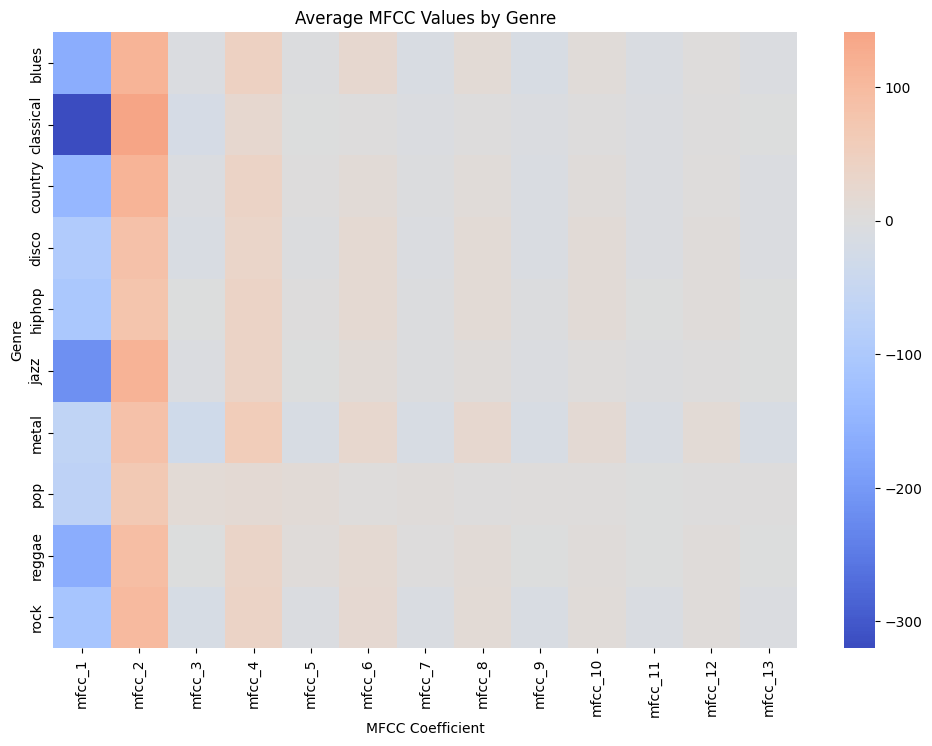

In [13]:
# genereate mfcc columns
mfcc_cols = [f'mfcc_{i}' for i in range(1, 14)]  

# Group by genre and calculate mean MFCCs
mfcc_means = features_df.groupby('genre')[mfcc_cols].mean()

# Visualize as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(mfcc_means, cmap='coolwarm', center=0)
plt.title('Average MFCC Values by Genre')
plt.ylabel('Genre')
plt.xlabel('MFCC Coefficient')

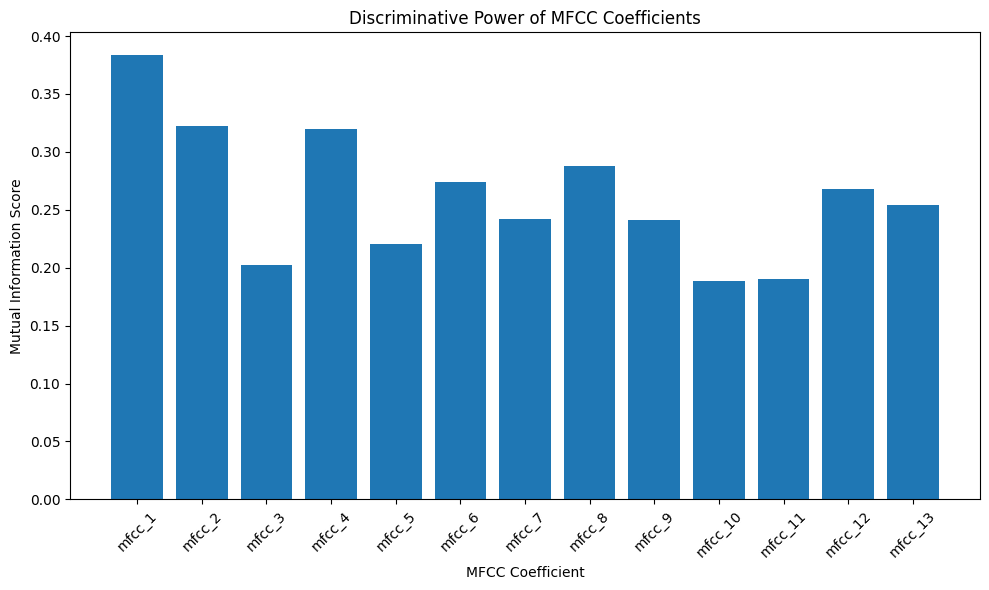

In [15]:
# Let's also look at the discriminative power of each MFCC
from sklearn.feature_selection import mutual_info_classif

# Calculate mutual information scores
mi_scores = mutual_info_classif(features_df[mfcc_cols], features_df['genre'])

# Create a bar plot of MFCC importance
plt.figure(figsize=(10, 6))
plt.bar(mfcc_cols, mi_scores)
plt.title('Discriminative Power of MFCC Coefficients')
plt.xlabel('MFCC Coefficient')
plt.ylabel('Mutual Information Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

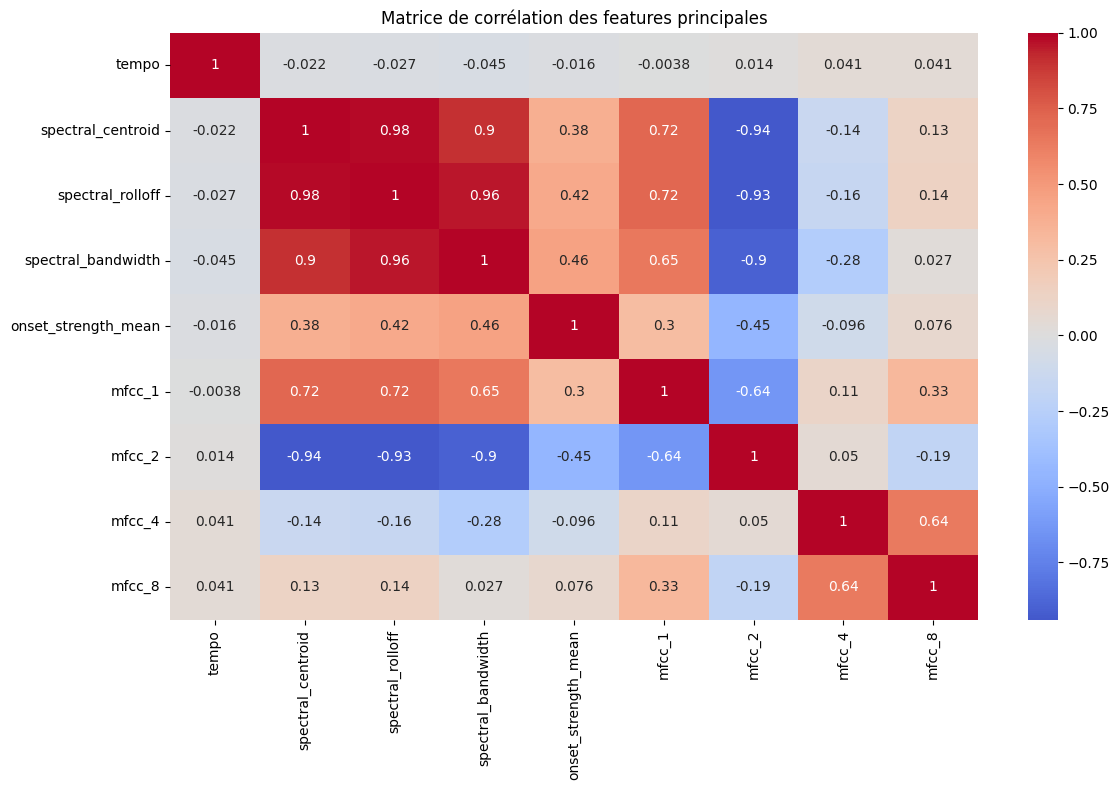

In [14]:
important_features = ['tempo', 'spectral_centroid', 'spectral_rolloff', 
                     'spectral_bandwidth', 'onset_strength_mean', 'mfcc_1', 'mfcc_2', 'mfcc_4', 'mfcc_8']

plt.figure(figsize=(12, 8))
sns.heatmap(features_df_scaled[important_features].corr(), 
            annot=True, cmap='coolwarm', center=0)
plt.title('Matrice de corrélation des features principales')
plt.tight_layout()
plt.show()

## Spectrogams - MelSpectrograms - Chromagrams

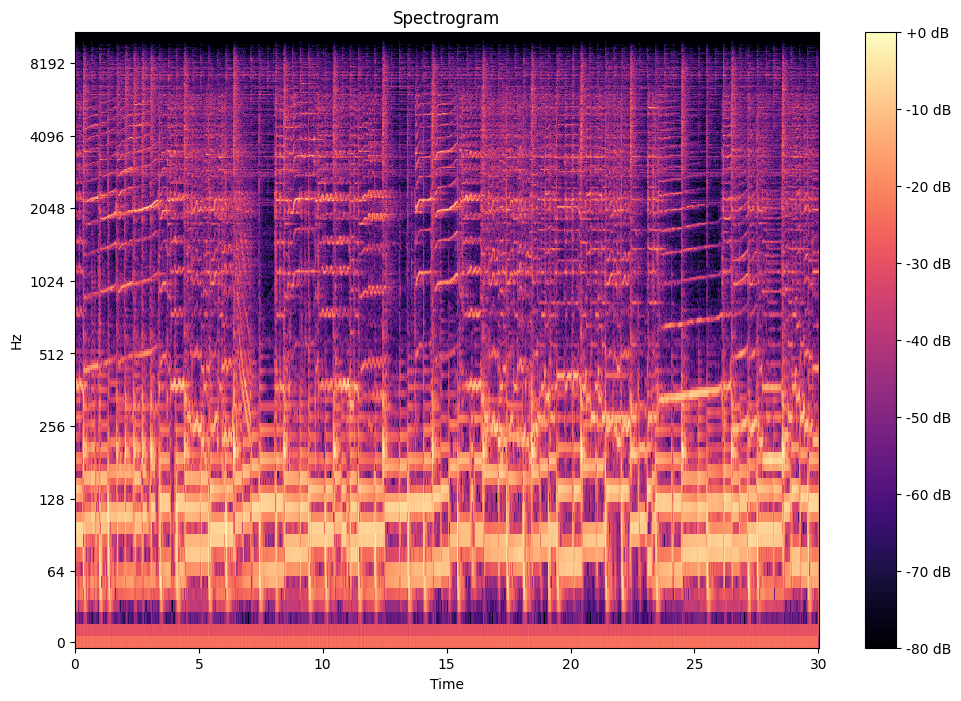

In [11]:
# short fourier transform performed on the first blues signal
y, sr = librosa.load(df[df['genre']=='blues']['filename'].iloc[0])
D = librosa.stft(y)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
plt.figure(figsize=(12, 8))
librosa.display.specshow(S_db, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.show()


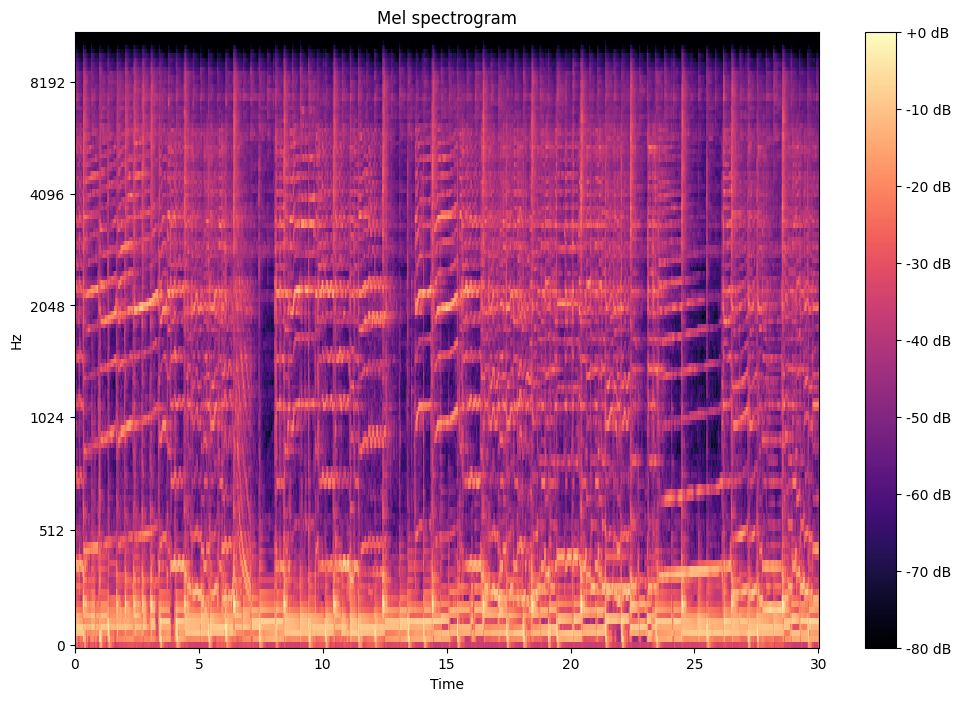

In [16]:
# melspectrogram performed on the first blues signal
y, sr = librosa.load(df[df['genre']=='blues']['filename'].iloc[0])
S = librosa.feature.melspectrogram(y=y, sr=sr)
S_db = librosa.power_to_db(S, ref=np.max)
plt.figure(figsize=(12, 8))
librosa.display.specshow(S_db, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.show()


In [22]:
# save for each genre the mel spectrogram in a folder 
output_dir = 'mel_spectrograms'
os.makedirs(output_dir, exist_ok=True)

for genre in genres:
    genre_dir = os.path.join(output_dir, genre)
    os.makedirs(genre_dir, exist_ok=True)
    genre_files = df[df['genre'] == genre]['filename'].values
    for i, file in enumerate(genre_files):
        y, sr = librosa.load(file)
        S = librosa.feature.melspectrogram(y=y, sr=sr)
        S_dB = librosa.power_to_db(S, ref=np.max)
        plt.figure(figsize=(12, 8))
        librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
        plt.colorbar(format='%+2.0f dB')
        plt.title(f'{genre} signal {i+1}')
        plt.savefig(os.path.join(genre_dir, f'{genre}_{i+1}.png'))
        plt.close()
print("Done saving mel spectrograms!")


Done saving mel spectrograms!


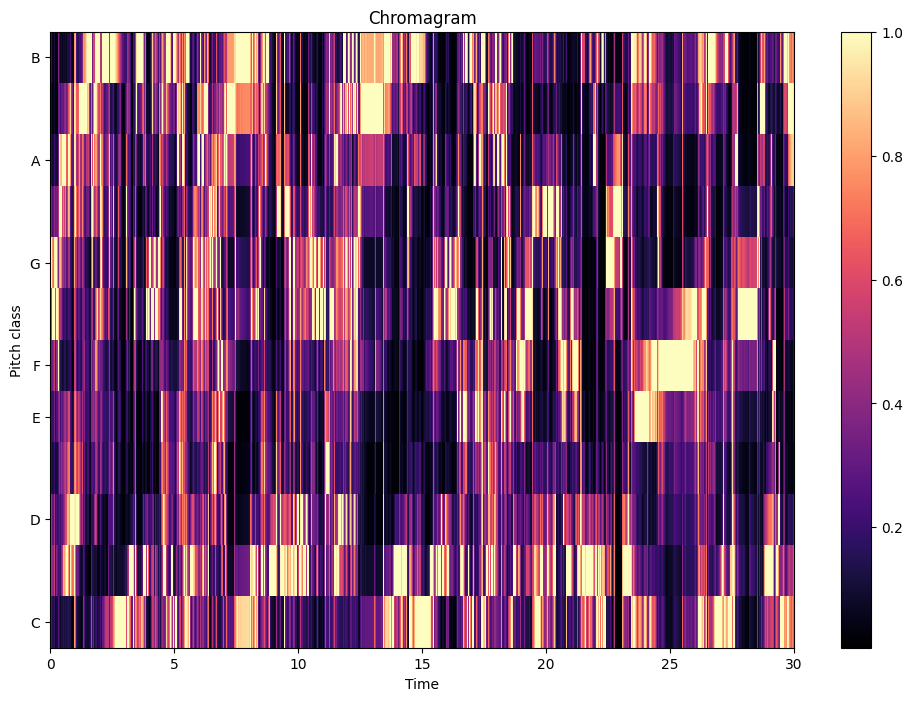

In [13]:
# plot the chromagram of the first blues signal

y, sr = librosa.load(df[df['genre']=='blues']['filename'].iloc[0])
chroma = librosa.feature.chroma_stft(y=y, sr=sr)
plt.figure(figsize=(12, 8))
librosa.display.specshow(chroma, y_axis='chroma', x_axis='time')
plt.colorbar()
plt.title('Chromagram')
plt.show()


In [ ]:
# save the chromagram for each genre in a folder
output_dir = 'chromagrams'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for genre in genres:
    genre_dir = os.path.join(output_dir, genre)
    os.makedirs(genre_dir, exist_ok=True)
    genre_files = df[df['genre'] == genre]['filename'].values
    for i, file in enumerate(genre_files):
        y, sr = librosa.load(file)
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        plt.figure(figsize=(12, 8))
        librosa.display.specshow(chroma, y_axis='chroma', x_axis='time')
        plt.colorbar()
        plt.title(f'{genre} signal {i+1}')
        plt.savefig(os.path.join(genre_dir, f'{genre}_{i+1}.png'))
        plt.close()
print("Done saving chromagrams!")


## Normalizing the melspectrograms

***Why Normalize the melspectrograms ?***

- The music signals can have very different amplitudes across recordings, even within the same genre. NOrmalizing helps make these comparable 
- Model Training : Normalizing typically leads to better model convergence and performance

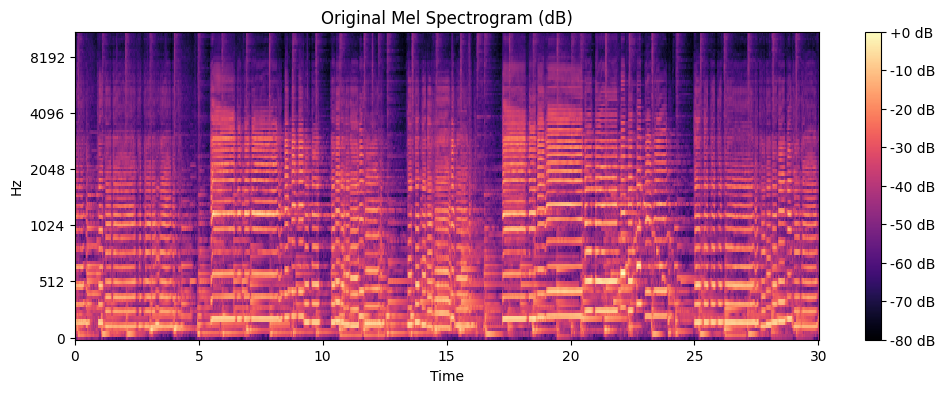

In [23]:
jazz_file = df[df['genre'] == 'jazz']['filename'].values[0]
y, sr = librosa.load(jazz_file)

# mel spectrogram
S = librosa.feature.melspectrogram(y=y, sr=sr)

# convert to dB
S_dB = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(S_dB, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Original Mel Spectrogram (dB)')
plt.show()

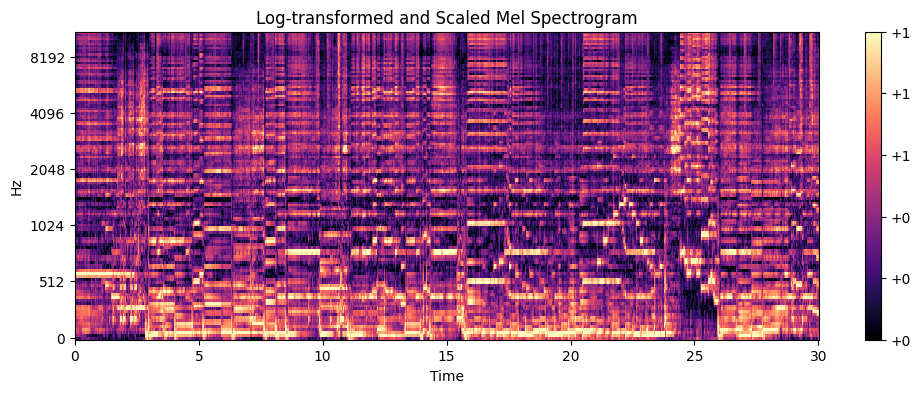


Log-transformed distribution statistics:
Mean: 0.40
Std: 0.21
Min: 0.00
Max: 1.00


In [35]:
# Method 1: Log transformation followed by MinMax scaling
# Adding a small constant to avoid log(0)
eps = 1e-6
mel_spec_log = np.log(S + eps)

# Scale to [0, 1] range
scaler = MinMaxScaler(feature_range=(0, 1))
mel_spec_log_scaled = scaler.fit_transform(mel_spec_log)

# Plot the log-transformed and scaled spectrogram
plt.figure(figsize=(12, 4))
librosa.display.specshow(mel_spec_log_scaled, sr=sr, hop_length=512, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f')
plt.title('Log-transformed and Scaled Mel Spectrogram')
plt.show()

print("\nLog-transformed distribution statistics:")
print(f"Mean: {np.mean(mel_spec_log_scaled):.2f}")
print(f"Std: {np.std(mel_spec_log_scaled):.2f}")
print(f"Min: {np.min(mel_spec_log_scaled):.2f}")
print(f"Max: {np.max(mel_spec_log_scaled):.2f}")

In [43]:
# Parameters
output_dir = 'mel_spectrograms_log_scaled'
os.makedirs(output_dir, exist_ok=True)
eps = 1e-6

# Create the scaler with range [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))

# Process files by genre
for genre in genres:
    genre_dir = os.path.join(output_dir, genre)
    os.makedirs(genre_dir, exist_ok=True)
    genre_files = df[df['genre'] == genre]['filename'].values
    
    for i, file in enumerate(genre_files):
        # Load the audio file (30 seconds duration)
        y, sr = librosa.load(file, duration=30.0)
        
        # Compute mel spectrogram
        S = librosa.feature.melspectrogram(y=y, sr=sr)
        S_log = np.log(S + eps)
        
        # Reshape and scale
        S_reshaped = S_log.T  # Transpose for scaler compatibility
        S_log_scaled = scaler.fit_transform(S_reshaped).T  # Scale and transpose back
        
        # Save the scaled spectrogram as an image
        plt.figure(figsize=(12, 8))
        librosa.display.specshow(S_log_scaled, sr=sr, x_axis='time', y_axis='mel')
        plt.colorbar(format='%+2.0f')
        plt.title(f'{genre} signal {i+1}')
        plt.savefig(os.path.join(genre_dir, f'{genre}_{i+1}.png'))
        plt.close()

print("Done saving log-transformed and scaled mel spectrograms!")

Done saving log-transformed and scaled mel spectrograms!


# Dimension Reduction

### T-SNE : L’algorithme de réduction de dimensionnalité appelé t-distributed stochastic neighbor embedding (t-SNE) est un algorithme d’apprentissage non supervisé. Développé par Laurens van der Maaten et Geoffrey Hinton, il permet d’analyser des données décrites dans des espaces à forte dimensionnalité (via un grand nombre de descripteurs) pour les représenter dans des espaces à deux ou trois dimensions. Cet algorithme est très utilisé car il facilite la visualisation de données ayant beaucoup de descripteurs.

### T-SNE est un algorithme non-linéaire de “feature extraction” qui construit une nouvelle représentation des données de telle sorte que les données proches dans l’espace original aient une probabilité élevée d’avoir des représentations proches dans le nouvel espace. A l’inverse, les données qui sont éloignées dans l’espace original, ont une probabilité faible d’avoir des représentations proches dans le nouvel espace.

In [6]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features_df_scaled[numeric_features])

# t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(features_df_scaled[numeric_features])

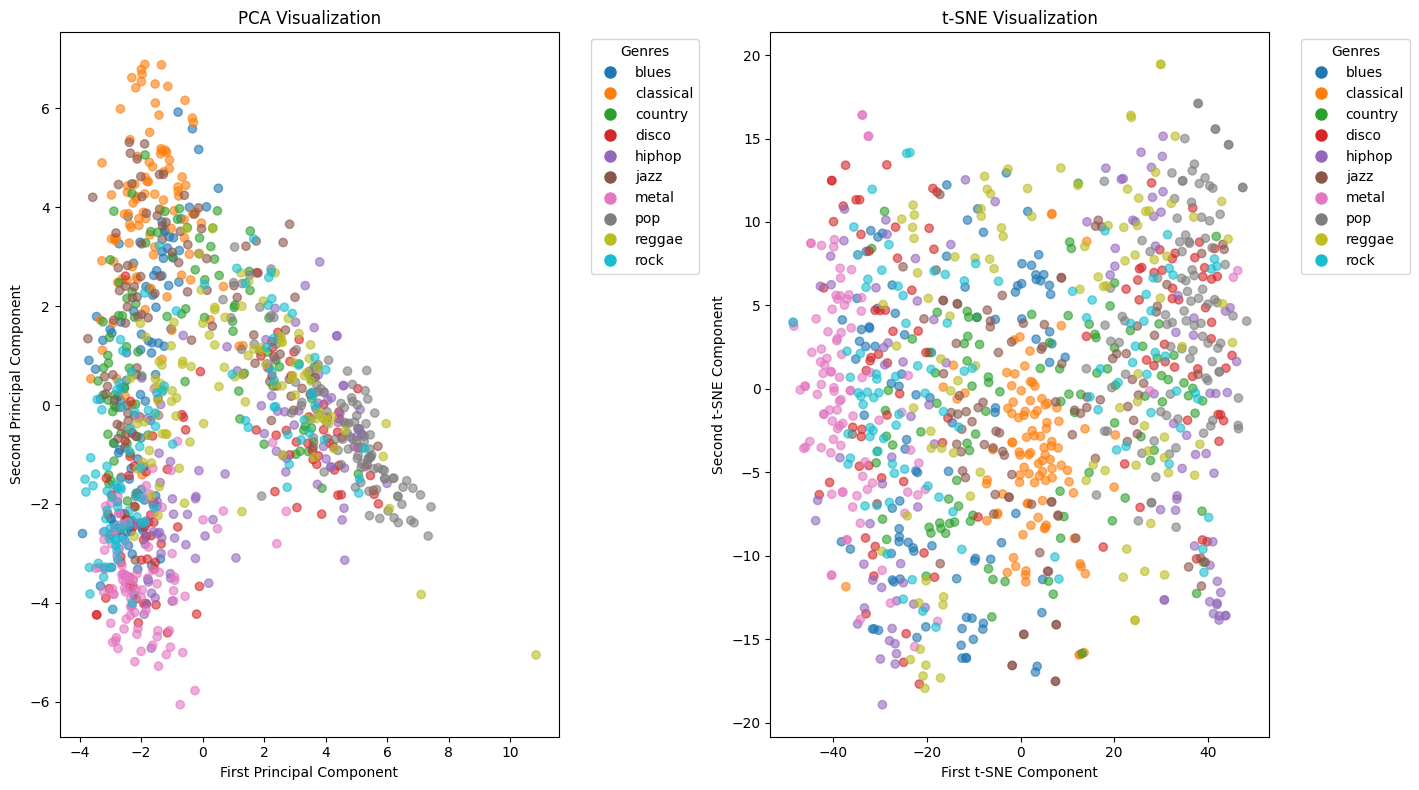

In [8]:
# Create a figure with enough space for the plots and legend
plt.figure(figsize=(20, 8))

# Get unique genres and their color mapping
genres = np.unique(features_df['genre'])
genre_ids = pd.factorize(features_df['genre'])[0]

# Create custom legend elements
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', 
                         markerfacecolor=plt.cm.tab10(i / len(genres)), 
                         label=genre,
                         markersize=10)
                  for i, genre in enumerate(genres)]

# PCA Plot
plt.subplot(131)
plt.scatter(pca_result[:, 0], pca_result[:, 1], 
           c=genre_ids, 
           cmap='tab10', 
           alpha=0.6)
plt.title('PCA Visualization')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.legend(handles=legend_elements, 
          title="Genres", 
          bbox_to_anchor=(1.05, 1),
          loc='upper left')

# t-SNE Plot
plt.subplot(132)
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], 
           c=genre_ids, 
           cmap='tab10', 
           alpha=0.6)
plt.title('t-SNE Visualization')
plt.xlabel('First t-SNE Component')
plt.ylabel('Second t-SNE Component')
plt.legend(handles=legend_elements, 
          title="Genres", 
          bbox_to_anchor=(1.05, 1),
          loc='upper left')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

- PCA Visualization:
    The PCA plot shows some interesting patterns:

   -  There's a clear separation between some genres, particularly metal (pink dots) and classical (orange dots) which tend to cluster in different regions. This suggests these genres have quite distinct audio characteristics.
   -  The first principal component (x-axis) seems to separate genres based on their overall intensity or energy - notice how classical music tends toward one side while metal and rock cluster on the other.
   - However, there's significant overlap in the center of the plot between genres like jazz, blues, and country. This indicates these genres share many similar audio characteristics, which makes intuitive sense given their historical relationships and similar instrumental compositions.

- t-SNE Visualization:
    The t-SNE plot reveals different patterns:

    - It shows more local structure and clusters than PCA, which is expected since t-SNE is better at preserving local relationships.
    - You can see small clusters of the same genre forming throughout the space, suggesting there are subgroups within each genre that share similar characteristics.
    - The classical genre (orange) shows particularly interesting clustering, suggesting it might be one of the more distinctive genres in the dataset.

- Key Insights:

    - No genre is completely separable from the others, which reflects the reality that musical genres often blend and share characteristics.
    - Classical and metal music appear to be the most distinctively characterized genres in the current feature space.
    - The substantial overlap between certain genres (like blues, jazz, and country) suggests these might be harder to classify accurately with the current feature set.

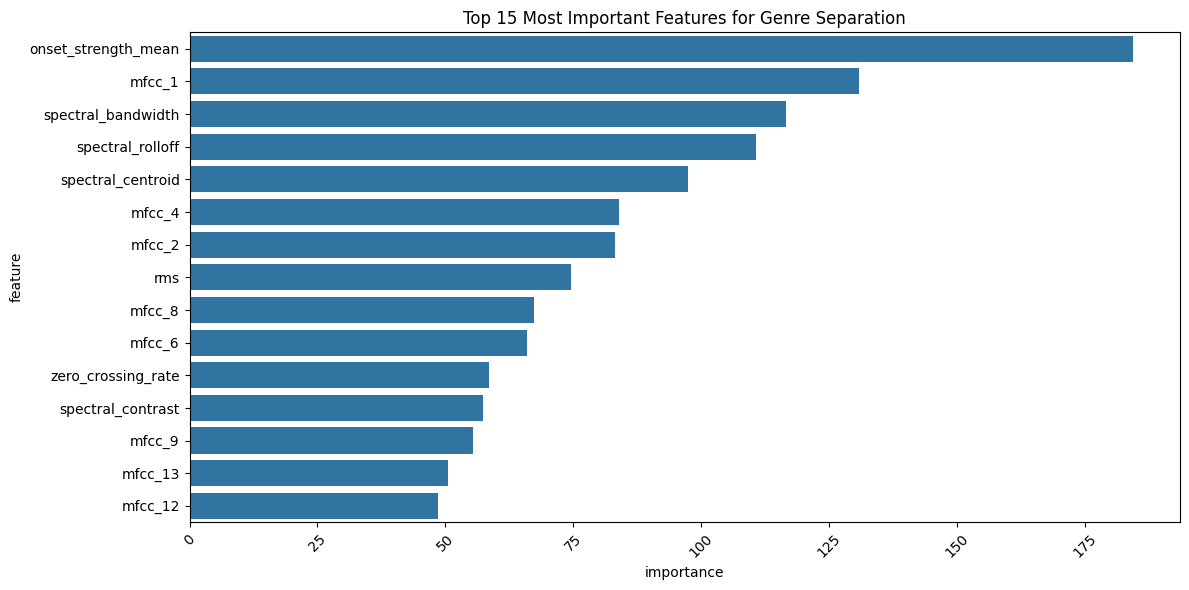

In [13]:
# Prepare the features and target
X = features_df.select_dtypes(include=['float64'])  # Numerical features only
y = features_df['genre']

# Use SelectKBest to rank features by their F-scores
selector = SelectKBest(score_func=f_classif, k='all')
selector.fit(X, y)

# Create a feature importance DataFrame
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': selector.scores_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Visualize feature importance
plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importance.head(15), x='importance', y='feature')
plt.title('Top 15 Most Important Features for Genre Separation')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [15]:
# Based on the feature importance analysis, let's select the top features
# This often improves separation by removing noise from less relevant features
top_features = feature_importance['feature'].head(20).tolist()  # Taking top 20 features

# Create a new DataFrame with only the most important features
X_selected = X[top_features]

# Scale the features using RobustScaler (often better than StandardScaler for audio features)
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_selected)

In [19]:
# Let's try a different approach to t-SNE with optimized parameters
# We'll first reduce dimensionality with PCA, then apply t-SNE
# This is a common practice that often yields better results

# First step: PCA to reduce to an intermediate dimension
n_components_pca = 20  
''' 
    n_components must not exceed the smaller of the number of samples (n_samples) 
    or the number of features (n_features). 
    In our case, min(n_samples, n_features) = 20.
'''
pca = PCA(n_components=n_components_pca)
X_pca_intermediate = pca.fit_transform(X_scaled)

# Second step: t-SNE with optimized parameters
tsne_optimized = TSNE(
    n_components=2,
    perplexity=40,  # Increased perplexity for better global structure
    early_exaggeration=12,  # Slightly higher for better separation
    learning_rate=200,  # Adjusted learning rate
    n_iter=2000,  # More iterations for better convergence
    random_state=42
)

X_tsne_optimized = tsne_optimized.fit_transform(X_pca_intermediate)

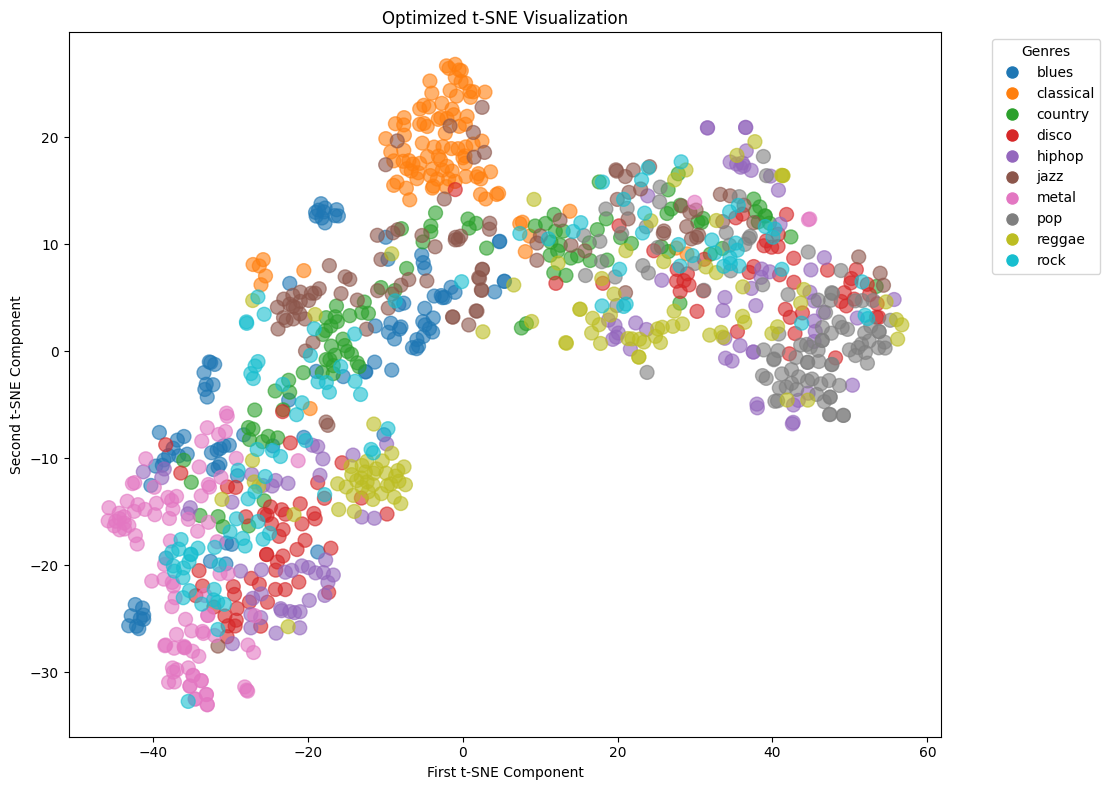

In [20]:
# Create an improved visualization with the optimized results
plt.figure(figsize=(20, 8))

# Create custom legend elements
genres = np.unique(y)
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                             markerfacecolor=plt.cm.tab10(i / len(genres)), 
                             label=genre, markersize=10)
                  for i, genre in enumerate(genres)]

# Plot optimized t-SNE results
plt.subplot(121)
scatter = plt.scatter(X_tsne_optimized[:, 0], X_tsne_optimized[:, 1],
                     c=pd.factorize(y)[0],
                     cmap='tab10',
                     alpha=0.6,
                     s=100)  # Increased point size for better visibility

plt.title('Optimized t-SNE Visualization')
plt.xlabel('First t-SNE Component')
plt.ylabel('Second t-SNE Component')
plt.legend(handles=legend_elements,
          title="Genres",
          bbox_to_anchor=(1.05, 1),
          loc='upper left')

plt.tight_layout()
plt.show()

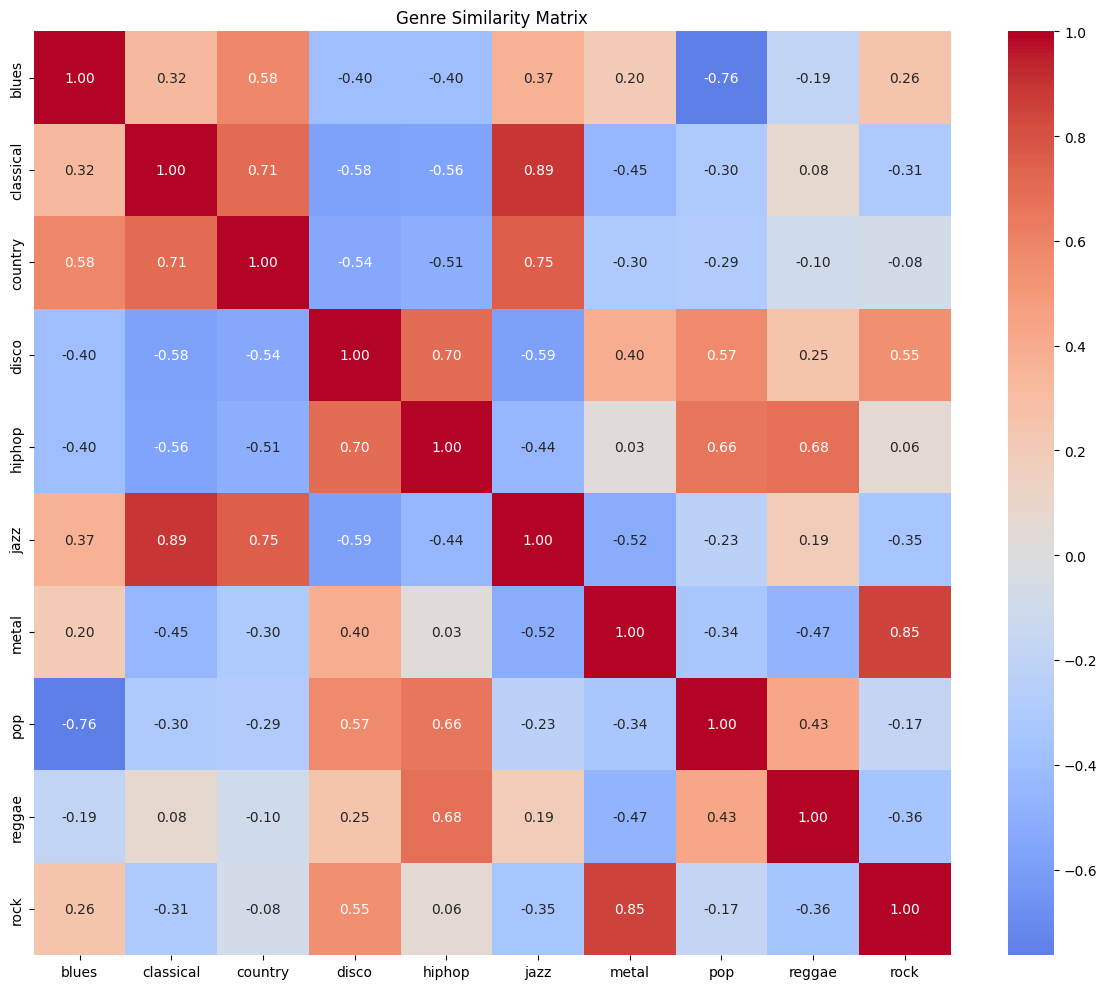

In [21]:
# Let's also examine the separation in feature space using a correlation matrix
# This can help us understand relationships between genres

# Create genre-specific average features
genre_profiles = []
for genre in genres:
    genre_mask = y == genre
    genre_avg = pd.DataFrame(X_scaled[genre_mask]).mean()
    genre_profiles.append(genre_avg)

genre_profiles_df = pd.DataFrame(genre_profiles, index=genres)

# Create and plot correlation matrix between genres
plt.figure(figsize=(12, 10))
sns.heatmap(genre_profiles_df.T.corr(), 
            annot=True, 
            cmap='coolwarm', 
            center=0,
            fmt='.2f')
plt.title('Genre Similarity Matrix')
plt.tight_layout()
plt.show()

Strong Positive Correlations:

Classical and Jazz show a very strong correlation (0.89), which makes sense as both genres often feature complex harmonies and acoustic instruments
Metal and Rock have a strong correlation (0.85), reflecting their shared characteristics of distorted guitars and intense dynamics
Hip-hop and Disco show a notable correlation (0.70), likely due to their rhythm-driven nature and similar tempo ranges

Strong Negative Correlations:

Blues and Pop show a strong negative correlation (-0.76), indicating very different acoustic characteristics
Classical music and Disco show significant negative correlation (-0.58), which reflects their contrasting musical elements
Jazz and Metal also show negative correlation (-0.52), highlighting their different approaches to instrumentation and composition

Looking at the optimized t-SNE visualization, we can see how these relationships manifest in the two-dimensional space:

Clear Clustering:


Classical music (orange) forms a distinct cluster in the upper portion of the plot, showing its unique characteristics
Metal and Rock (pink and turquoise) cluster together in the lower left, confirming their high correlation
Hip-hop and Disco (purple and red) show proximity in certain regions, matching their positive correlation


Interesting Transitions:


There's a smooth transition between Rock, Metal, and Blues, suggesting these genres share some common features
Jazz (brown) appears somewhat scattered, suggesting it shares characteristics with multiple genres
Pop (gray) shows wide distribution, indicating it borrows elements from various genres

This improved visualization helps us understand why genre classification can be challenging:

Some genres have clear boundaries and distinct characteristics (like Classical)
Others show significant overlap (like Rock and Metal)
Some genres (like Pop and Jazz) are more diffuse, suggesting they encompass a wider range of musical styles

These insights can help us:

Better understand which genres might be more challenging to classify
Identify where we might need additional features to better distinguish similar genres
